In [1]:
import numpy as np
import pandas as pd
from DS_healpix_fragmentation import radec2pix, one_pixel_fragmentation, matr2dict
import os
from tqdm.notebook import tqdm

In [2]:
df = pd.concat([pd.read_csv('/home/rt2122/Data/clusters/planck_z.csv'), 
                pd.read_csv('/home/rt2122/Data/clusters/acts/act_found_pz_rot_28.csv')])

In [3]:
df['pix'] = radec2pix(df['RA'], df['DEC'], 2)

In [4]:
size = 64
patches_coords = []
for ipix in tqdm(range(48)):
    
    df_cur = df[df['pix'] == ipix]
    matr = one_pixel_fragmentation(2, ipix, 10)
    mdict = matr2dict(matr)
    
    all_pixels = set()
    for pix in radec2pix(df_cur['RA'], df_cur['DEC'], 2048):
        x_cl, y_cl = mdict[pix]
        all_pixels = all_pixels.union(set(
            [(x, y) for x in range(max(x_cl-size+1, 0), 
                                   min(x_cl+1,matr.shape[0]-size)) 
                for y in range(max(y_cl-size+1, 0), 
                               min(y_cl+1,matr.shape[1]-size))]))
        
    pic = np.load(os.path.join('/home/rt2122/Data/Planck/pregen_pics/', 
                               str(ipix) + '.npy'))
    
    outliers_coords = np.where(np.logical_or(pic < -4000, pic > 200000))
    outliers_pixels = set()
    for x_out, y_out in np.array(outliers_coords[:2]).T:
        outliers_pixels = outliers_pixels.union(set(
            [(x, y) for x in range(max(x_out-size+1, 0), 
                                   min(x_out+1,matr.shape[0]-size)) 
                for y in range(max(y_out-size+1, 0), 
                               min(y_out+1,matr.shape[1]-size))]))
    #list of patches with bad values

    all_pixels = all_pixels.difference(outliers_pixels)
    if len(all_pixels) == 0:
        continue
    
    all_pixels = np.array(list(all_pixels))
    
    cur_coords = pd.DataFrame({'x' : all_pixels[:,0], 'y' : all_pixels[:,1], 
                             'pix' : [ipix] * all_pixels.shape[0]})
    patches_coords.append(cur_coords)

In [5]:
patches_coords = pd.concat(patches_coords, ignore_index=True)
print(patches_coords.shape)
patches_coords.head()

(5292281, 3)


,x,y,pix
0,679,437,0
1,720,438,0
2,780,489,0
3,491,386,0
4,59,729,0


In [6]:
patches_coords = patches_coords[::4]
len(patches_coords)

1323071

In [7]:
patches_coords.to_csv('/home/rt2122/Data/Planck/coords/pz_act_found_patches.csv', 
                      index=False)

In [4]:
def gen_data_while_training(big_pixels, batch_size, patches_file, pregen_pics, pregen_masks, size=64):
    import numpy as np
    import pandas as pd
    import os
    from DS_healpix_fragmentation import radec2pix
    
    patches = pd.read_csv(patches_file)
    patches = patches[np.in1d(patches['pix'], big_pixels)]
    patches.index = np.arange(len(patches))
    
    pic_dict = {}
    mask_dict = {}
    
    for pix in big_pixels:
        pic_dict[pix] = np.load(os.path.join(pregen_pics, str(pix) + '.npy'))
        mask_dict[pix] = np.load(os.path.join(pregen_masks, str(pix) + '.npy'))
    
    while 4:
        sample = patches.sample(frac=1)
        
        for i in range(0, len(patches), batch_size):
            pics = []
            masks = []
            
            cur_pix = np.array(sample['pix'].iloc[i:i+batch_size])
            cur_x = np.array(sample['x'].iloc[i:i+batch_size])
            cur_y = np.array(sample['y'].iloc[i:i+batch_size])
            
            for i in range(batch_size):
                pix = cur_pix[i]
                x = cur_x[i]
                y = cur_y[i]
                
                pics.append(pic_dict[pix][x:x+size,y:y+size,:])
                masks.append(mask_dict[pix][x:x+size,y:y+size,:])
            
            yield np.stack(pics), np.stack(masks)

In [5]:
from DS_Planck_Unet import *

In [6]:
val_gen = gen_data_while_training(val_pix, 20, 
        '/home/rt2122/Data/Planck/coords/pz_act_patches.csv', 
        '/home/rt2122/Data/Planck/pregen_act/')

(20, 64, 64, 6) (20, 64, 64, 1)


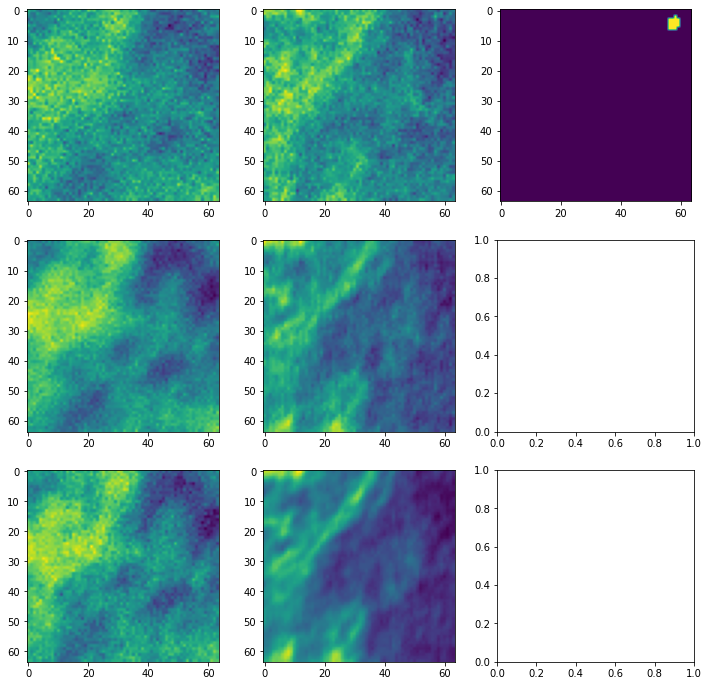

In [12]:
check_gen(val_gen)

In [4]:
pd.read_csv('/home/rt2122/Data/Planck/coords/pz_only_patches.csv')

,x,y,pix
0,720,438,0
1,780,489,0
2,491,386,0
3,59,729,0
4,647,899,0
...,...,...,...
3665328,570,494,47
3665329,262,149,47
3665330,368,545,47
3665331,74,98,47


In [ ]:
len()